Notebook for two-view reconstruction with inertial data.

This code is written upon vo_benchmark.ipynb.

Author: Jongwon Lee

In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R
import time

import vo, vio
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Read data

In [2]:
# Specify the dataset (should be 'kitti' or 'euroc')
# chosen_dataset = 'euroc'
chosen_dataset = 'kitti'

assert(chosen_dataset in ['kitti', 'euroc'])

### Provide settings

In [3]:
# When matching (max threshold for ratio test)
if chosen_dataset == 'euroc': 
    matching_threshold = 0.5 # I recommend 0.1 for KITTI and 0.5 for EuRoC
else:
    matching_threshold = 0.3 # I recommend 0.1 for KITTI and 0.5 for EuRoC

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

In [4]:
if chosen_dataset == 'euroc': # Note: euroc takes a bit longer to load.
    # Use EuRoC MAV
    
    # MAV video folder
    mav_video_folder = Path('./data/mav0')


    # Read MAV data
    dataset_info = utils.read_data_mav(mav_video_folder)
    print("Read dataset with keys: {}".format(sorted(list(dataset_info.keys()))))

    # Extract relevant data
    cam0_K = dataset_info['cam0_K']
    cam0_distortion = dataset_info['cam0_distortion']
    visual_inertial_data = dataset_info['visual_inertial_data']

    sigma_acc_wn = dataset_info['imu_accelerometer_noise_density']
    sigma_gyr_wn = dataset_info['imu_gyroscope_noise_density']
    sigma_acc_rw = dataset_info['imu_accelerometer_noise_density']
    sigma_gyr_rw = dataset_info['imu_gyroscope_random_walk']

    dt = 1/200 # IMU frequency

    # Get extrinsics
    T_inB_ofC = dataset_info['cam0_extrinsics']
    T_inC_ofB = np.block([[T_inB_ofC[:3,:3].T, (-T_inB_ofC[:3,:3].T @ T_inB_ofC[:3,-1])[:,np.newaxis]], [np.zeros(3), 1]])

    # Collate
    acc_meas, gyr_meas = utils.imu_collate(dataset_info['visual_inertial_data'])
    R_inR_ofB, v_inR_ofB, p_inR_ofB, b_a, b_w = utils.groundtruth_collate(dataset_info['visual_inertial_data'], True)

    # As EuRoC's ground-truth (MoCap) is not aligned with gravity (i.e., in world frame), we identify the orientation of MoCap frame in world frame
    gravity = np.array([0., 0., -9.81])

    g_inB = - np.mean(acc_meas[:10], axis=0)
    g_inW = gravity

    def align_vectors(g_inB, g_inW):
        # Normalize input vectors
        g_inB_unit = g_inB / np.linalg.norm(g_inB)
        g_inW_unit = g_inW / np.linalg.norm(g_inW)

        # Compute the axis of rotation
        v = np.cross(g_inB_unit, g_inW_unit)

        # Compute the angle of rotation
        cos_theta = np.dot(g_inB_unit, g_inW_unit)
        sin_theta = np.linalg.norm(v)
        theta = np.arctan2(sin_theta, cos_theta)

        v /= np.linalg.norm(v)
        
        # Compute the rotation matrix
        Rot = R.from_rotvec(theta*v)
        return Rot

    # Compute rotation matrix
    R_inW_ofB = align_vectors(g_inB, g_inW)
    print("Rotation Matrix:\n", R_inW_ofB.as_matrix())

    R_inW_ofB.apply(g_inB)

    R_inW_ofR = R_inW_ofB * R_inR_ofB[:10].mean().inv()
    R_inW_ofB = R_inW_ofR * R_inR_ofB
    v_inW_ofB = R_inW_ofR.apply(v_inR_ofB)
    p_inW_ofB = R_inW_ofR.apply(p_inR_ofB)


    

else:
    # Use KITTI
    kitti_base_path = './data/kitti'
    kitti_date = '2011_09_26'
    kitti_drive = '0022'

    # Read KITTI data
    dataset_info = utils.read_data_kitti(kitti_base_path, kitti_date, kitti_drive)

    # Extract relevant data
    cam0_K = dataset_info['cam0_K']
    cam0_distortion = dataset_info['cam0_distortion']
    visual_inertial_data = dataset_info['visual_inertial_data']

    T_inC_ofB = dataset_info['cam0_extrinsics']

    sigma_acc_wn = 1e-4  # accelerometer white noise sigma
    sigma_gyr_wn = 1e-6  # gyroscope white noise sigma
    sigma_acc_rw = 1e-5  # accelerometer random walk sigma
    sigma_gyr_rw = 1e-7  # gyroscope random walk sigma

    # KITTI has data at 10 Hz
    dt = 0.1

    # Collate
    acc_meas, gyr_meas = utils.imu_collate(visual_inertial_data)
    R_inW_ofB, v_inW_ofB, p_inW_ofB, b_a, b_w = utils.groundtruth_collate(visual_inertial_data, False)

### Create random generator

In [5]:
rng = utils.create_rng(None)

seeding RNG with 169881423


### Create image keypoint feature extractor

In [6]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [7]:
if chosen_dataset == 'euroc': # Note: euroc takes a bit longer to load.
    # Use EuRoC MAV
    chosen_index = 5000
    advance = 10
else:
    chosen_index = 50
    advance = 5


# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vio.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                         first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vio.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                         second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

# Perform two-view reconstruction
R_inC_ofB = T_inC_ofB[:3,:3]
p_inC_ofB = T_inC_ofB[:3,-1]

R_inC_ofW = R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T
p_inC_ofW = - R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx] + p_inC_ofB
tracks = vio.vo_2view(views, matching_threshold, cam0_K, R_inC_ofW, p_inC_ofW, rng, use_opencv=False)

found 145 good matches
found 145 inliers



REPROJECTION ERRORS
 Image  0 (  145 points) : (mean, std, max, min) = (  0.08,   0.09,   0.54,   0.00)
 Image (raw reprojection)  0 (  145 points) : (mean, std, max, min) = (  0.08,   0.09,   0.54,   0.00)
 Image  1 (  145 points) : (mean, std, max, min) = (  0.09,   0.09,   0.58,   0.00)
 Image (raw reprojection)  1 (  145 points) : (mean, std, max, min) = (  0.09,   0.09,   0.58,   0.00)


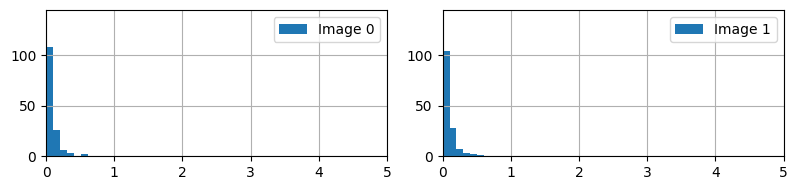

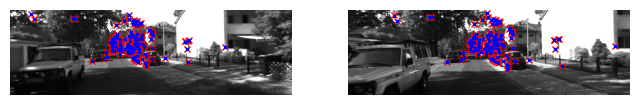

In [8]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Get post-optimization solution

Run below to keep the initial views and tracks

In [9]:
views_ini = views.copy()
tracks_ini = tracks.copy()

Run two-view reconstruction with inertial data

In [10]:
T_inB0_ofW = np.block([[R_inW_ofB[first_frame_idx].as_matrix().T, - R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC0_ofW = T_inC_ofB @ T_inB0_ofW

T_inB1_ofW = np.block([[R_inW_ofB[second_frame_idx].as_matrix().T, - R_inW_ofB[second_frame_idx].as_matrix().T @ p_inW_ofB[second_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC1_ofW = T_inC_ofB @ T_inB1_ofW

T_inC0_ofW = None   # comment this out when you'd like to use ground truth as initial guess
T_inC1_ofW = None   # comment this out when you'd like to use ground truth as initial guess

tic = time.time()

views, tracks, initial_values, results = vio.vio_nonlinear_optimize(views_ini, tracks_ini, acc_meas[first_frame_idx:second_frame_idx], gyr_meas[first_frame_idx:second_frame_idx], 
                                                                    cam0_K, T_inC_ofB, max_reprojection_err,
                                                                    sigma_acc_wn, sigma_gyr_wn, sigma_acc_rw, sigma_gyr_rw, dt,
                                                                    np.mean(b_a, axis=0), np.mean(b_a, axis=0), np.mean(b_w, axis=0), np.mean(b_w, axis=0),
                                                                    v_inW_ofB[first_frame_idx], v_inW_ofB[second_frame_idx],
                                                                    T_inC0_ofW, T_inC1_ofW)

toc = time.time()

print(f"{toc - tic:.2f} [s]")

[2024-05-09 00:54:21.879] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1.402e+10/0.000e+00/8.047e+08, rel reduction: 9.42600e-01
[2024-05-09 00:54:21.900] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 8.047e+08/0.000e+00/4.179e+06, rel reduction: 9.94807e-01
[2024-05-09 00:54:21.920] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 4.179e+06/0.000e+00/1.055e+06, rel reduction: 7.47421e-01
[2024-05-09 00:54:21.941] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.055e+06/0.000e+00/3.384e+05, rel reduction: 6.79403e-01
[2024-05-09 00:54:21.961] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 3.384e+05/0.000e+00/1.286e+05, rel reduction: 6.19838e-01
[2024-05-09 00:54:21.982] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 1.286e+05/0.000e+00/3.109e+03, rel reduction: 9.75827e-01
[2024-05-09 00:54:22.0

Evaluate change in position between frames

In [11]:
# Symforce - Initial values
R_inW_ofC0_ini = results.initial_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_ini = - R_inW_ofC0_ini @ results.initial_values['T_inC0_ofW'].t

R_inW_ofB0_ini = R_inW_ofC0_ini @ R_inC_ofB
p_inW_ofB0_ini = R_inW_ofC0_ini @ p_inC_ofB + p_inW_ofC0_ini

R_inW_ofC1_ini = results.initial_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_ini = - R_inW_ofC1_ini @ results.initial_values['T_inC1_ofW'].t

R_inW_ofB1_ini = R_inW_ofC1_ini @ R_inC_ofB
p_inW_ofB1_ini = R_inW_ofC1_ini @ p_inC_ofB + p_inW_ofC1_ini

# Symforce - Optimized values
R_inW_ofC0_sf = results.optimized_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_sf = - R_inW_ofC0_sf @ results.optimized_values['T_inC0_ofW'].t

R_inW_ofB0_sf = R_inW_ofC0_sf @ R_inC_ofB
p_inW_ofB0_sf = R_inW_ofC0_sf @ p_inC_ofB + p_inW_ofC0_sf

R_inW_ofC1_sf = results.optimized_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_sf = - R_inW_ofC1_sf @ results.optimized_values['T_inC1_ofW'].t

R_inW_ofB1_sf = R_inW_ofC1_sf @ R_inC_ofB
p_inW_ofB1_sf = R_inW_ofC1_sf @ p_inC_ofB + p_inW_ofC1_sf

# ground truth
R_inW_ofB0_gt = R_inW_ofB[first_frame_idx].as_matrix()
p_inW_ofB0_gt = p_inW_ofB[first_frame_idx]
v_inW_ofB0_gt = v_inW_ofB[first_frame_idx]

R_inW_ofB1_gt = R_inW_ofB[second_frame_idx].as_matrix()
p_inW_ofB1_gt = p_inW_ofB[second_frame_idx]
v_inW_ofB1_gt = v_inW_ofB[second_frame_idx]

Error evaluation on optimized results

In [12]:
p_inW_ofB0toB1_ini = p_inW_ofB1_ini - p_inW_ofB0_ini
R_inB1_ofB0_ini = R_inW_ofB1_ini.T @ R_inW_ofB0_ini

p_inW_ofB0toB1_sf = p_inW_ofB1_sf - p_inW_ofB0_sf
R_inB1_ofB0_sf = R_inW_ofB1_sf.T @ R_inW_ofB0_sf

v_inW_ofB0toB1_gt = v_inW_ofB1_gt - v_inW_ofB0_gt
p_inW_ofB0toB1_gt = p_inW_ofB1_gt - p_inW_ofB0_gt
R_inB1_ofB0_gt = R_inW_ofB1_gt.T @ R_inW_ofB0_gt

dR_err_ini = R.from_matrix(R_inB1_ofB0_ini.T @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
dR_err_sf = R.from_matrix(R_inB1_ofB0_sf.T @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
print(f'dR: {dR_err_ini} (init.) --> {dR_err_sf} (optm.) [deg] (xyz)')
print('dR scalar: {:.5f} (init.) --> {:.5f} (optm.) [deg]'.format(
    pose_metrics.rotational_error(R_inB1_ofB0_ini, R_inB1_ofB0_gt),
    pose_metrics.rotational_error(R_inB1_ofB0_sf, R_inB1_ofB0_gt),
))

dp_err_ini = p_inW_ofB0toB1_ini - p_inW_ofB0toB1_gt
dp_err_sf = p_inW_ofB0toB1_sf - p_inW_ofB0toB1_gt
print(f'dp: {np.linalg.norm(dp_err_ini):.2f} (init.) --> {np.linalg.norm(dp_err_sf):.2f} (optm.) [m]')

dR: [-0.05408792 -0.02376508 -0.12755577] (init.) --> [-0.1434648   0.03172517  0.73365728] (optm.) [deg] (xyz)
dR scalar: 0.00245 (init.) --> 0.01306 (optm.) [deg]
dp: 1.82 (init.) --> 0.27 (optm.) [m]


(Optional) Error evaluation on preintegrated results

In [13]:
gravity = results.initial_values['gravity']
dt_01 = results.initial_values['dt_01']
dR_01 = results.initial_values['dR_01']
dv_01 = results.initial_values['dv_01']
dp_01 = results.initial_values['dp_01']

dR_err_pi = R.from_matrix(dR_01 @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
print(f'dR_preintegrated: {dR_err_pi} [deg] (xyz)')
print('dR_preintegrated scalar: {:.5f} [deg]'.format(
    pose_metrics.rotational_error(dR_01, R_inB1_ofB0_gt)
))

v_inW_ofB0toB1_pi = R_inW_ofB0_gt @ dv_01 + gravity * dt_01
dv_err_pi = v_inW_ofB0toB1_pi - v_inW_ofB0toB1_gt

print(f'dv_preintegrated: {np.linalg.norm(v_inW_ofB0toB1_pi):.2f} [m/s] (abs err: {np.linalg.norm(dv_err_pi):.2f} [m/s], rel err: {np.linalg.norm(dv_err_pi)/np.linalg.norm(v_inW_ofB0toB1_gt)*100:.2f} [%])')

p_inW_ofB0toB1_pi = R_inW_ofB0_gt @ dp_01 + v_inW_ofB0_gt * dt_01 + 0.5 * gravity * dt_01 ** 2
dp_err_pi = p_inW_ofB0toB1_pi - p_inW_ofB0toB1_gt

print(f'dp_preintegrated: {np.linalg.norm(p_inW_ofB0toB1_pi):.2f} [m] (abs err: {np.linalg.norm(dp_err_pi):.2f} [m], rel err: {np.linalg.norm(dp_err_pi)/np.linalg.norm(p_inW_ofB0toB1_gt)*100:.2f} [%])')


dR_preintegrated: [-0.14346564  0.03172481  0.73365981] [deg] (xyz)
dR_preintegrated scalar: 0.26456 [deg]
dv_preintegrated: 0.91 [m/s] (abs err: 0.08 [m/s], rel err: 9.07 [%])
dp_preintegrated: 2.64 [m] (abs err: 0.32 [m], rel err: 11.35 [%])



REPROJECTION ERRORS
 Image  0 (   14 points) : (mean, std, max, min) = (  0.16,   0.09,   0.33,   0.03)
 Image (raw reprojection)  0 (   14 points) : (mean, std, max, min) = (  0.16,   0.09,   0.33,   0.03)
 Image  1 (   14 points) : (mean, std, max, min) = (  0.14,   0.08,   0.28,   0.02)
 Image (raw reprojection)  1 (   14 points) : (mean, std, max, min) = (  0.14,   0.08,   0.28,   0.02)


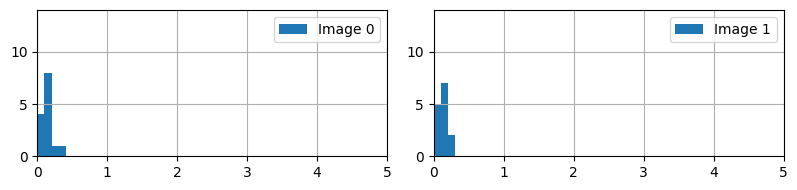

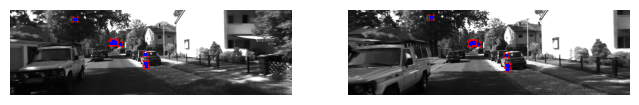

In [14]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

In [15]:
p_inW_ofB0toB1_ini

array([-0.93904967,  0.21540465, -0.01227016])

In [16]:
p_inW_ofB0toB1_sf

array([-2.54302093,  0.54472576,  0.10709966])

In [17]:
p_inW_ofB0toB1_gt

array([-2.73380162,  0.51904637, -0.08744049])